## Building Variational Auto-encoders using CNN in Pytorch

In [2]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import numpy as np
import os
from vae_model import VAE as model_architecture
from dataloader import CustomImageDataset
from matplotlib import pyplot as plt
import cv2
import generate_circle_data

In [3]:
vae_cnn_model = model_architecture(mode="run")
#input_tensor = torch.randn((4,3,128,128))
#reconstruction, mean, log_var, z = vae_cnn_model(input_tensor)

In [4]:
root_path="./"

### Add Circle Image in the dataset

In [5]:
os.system("rm dataset/train/circle*")
os.system("rm dataset/valid/circle*")
os.system("rm dataset/test/circle*")
generate_circle_data.run()

#### Model Parameters

In [6]:
LR = 1e-3
DIM = 128
EPOCH = 20
MODE = "train"
loss_fn = nn.MSELoss(reduction="sum") # nn.BCELoss(reduction="sum") # BCE and MSE both works fine.
optimizer = optim.Adam(vae_cnn_model.parameters(), lr=LR)
scheduler = StepLR(optimizer, step_size=5, gamma=0.05)

#### Data Transformations

In [7]:
transform = A.Compose(
                [   A.Resize(height=DIM, width=DIM),
                    ToTensorV2(),
                ],
                )

In [12]:
training_data = CustomImageDataset(transform, mode="train")
validation_data = CustomImageDataset(transform, mode="valid")
test_data = CustomImageDataset(transform, mode="test")
train_dataloader = DataLoader(training_data, batch_size=3, shuffle=True, pin_memory=True)
validation_dataloader = DataLoader(validation_data, batch_size=3, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=3, shuffle=True, pin_memory=True)

In [13]:
epoch_tr_loss,epoch_vl_loss, epoch_ts_loss = [],[], []
epoch_tr_acc,epoch_vl_acc, epoch_ts_acc = [], [], []
test_acc = 0.0
test_batch_run = 0
test_losses = []
ep_to_load_model = 1
valid_loss_min = np.Inf
clip_value = 5


#### Combined Training Loss

In [14]:
def combined_loss(reconstruction_loss, mu, log_var):
    KL_Divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + KL_Divergence

### VAE Training

In [15]:
for ep in range(EPOCH):
    counter = 0
    valid_batch_run = 0
    train_batch_run = 0
    train_losses = []
    valid_losses = []
    vae_cnn_model.train() # switch to train mode
    with tqdm(train_dataloader, unit=" Train batch") as tepoch:
        tepoch.set_description(f"Train Epoch {ep+1}")
        for input_images, gt_paths in tepoch:
            train_batch_run += 1
            optimizer.zero_grad()
            predictions, means, log_vars, z = vae_cnn_model(input_images.float())
            reconstruction_loss = loss_fn(input=predictions, target=input_images.float())
            loss_value = combined_loss(reconstruction_loss, means, log_vars)
            train_losses.append(loss_value.item())
            loss_value.backward()
            nn.utils.clip_grad_norm_(vae_cnn_model.parameters(), clip_value)
            optimizer.step()
    vae_cnn_model.eval() # switch to eval mode
    with tqdm(validation_dataloader, unit=" Valid batch") as vepoch:
        vepoch.set_description(f"Valid Epoch {ep+1}")
        for input_images, gt_paths in vepoch:
            with torch.no_grad():
                predictions, means, log_vars, z = vae_cnn_model(input_images.float()) # get the mean and log_var
                for pred in predictions:
                    prediction = pred.numpy()
                    prediction = prediction*255
                    img = cv2.merge([prediction[0],prediction[1],prediction[2]])
                    cv2.imwrite("pred/pred_"+str(counter)+".jpg",img)
                    counter = counter + 1
            reconstruction_loss = loss_fn(input=predictions, target=input_images.float())
            loss_value = combined_loss(reconstruction_loss, means, log_vars)
            valid_losses.append(loss_value.item())
            valid_batch_run += 1
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(valid_losses)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    print(f'Epoch {ep+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    if True: #epoch_val_loss <= valid_loss_min:
        os.system("rm ./models/vae*")
        print("removing stored weights of previous epoch")
        torch.save(vae_cnn_model.state_dict(), root_path+"models/vae_"+str(ep+1)+".pt")
        print("storing weights of current epoch")
        ep_to_load_model = ep+1
        #print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    scheduler.step()
    


        
        
        
        


Valid Epoch 1: 100%|██████████████████| 18/18 [00:00<00:00, 74.37 Valid batch/s]


Epoch 1
train_loss : 12678.01654296875 val_loss : 17306.42892795139
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 2: 100%|██████████████████| 18/18 [00:00<00:00, 69.55 Valid batch/s]


Epoch 2
train_loss : 12262.42626953125 val_loss : 15007.55943467882
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 3: 100%|██████████████████| 18/18 [00:00<00:00, 68.76 Valid batch/s]


Epoch 3
train_loss : 11904.004931640626 val_loss : 14363.00439453125
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 4: 100%|██████████████████| 18/18 [00:00<00:00, 66.37 Valid batch/s]


Epoch 4
train_loss : 11853.657802734375 val_loss : 16163.926215277777
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 5: 100%|██████████████████| 18/18 [00:00<00:00, 74.92 Valid batch/s]


Epoch 5
train_loss : 11906.966552734375 val_loss : 17362.266682942707
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 6: 100%|██████████████████| 18/18 [00:00<00:00, 66.26 Valid batch/s]


Epoch 6
train_loss : 11642.44474609375 val_loss : 15430.844319661459
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 7: 100%|██████████████████| 18/18 [00:00<00:00, 75.34 Valid batch/s]


Epoch 7
train_loss : 11759.842724609374 val_loss : 16311.43785264757
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 8: 100%|██████████████████| 18/18 [00:00<00:00, 77.53 Valid batch/s]


Epoch 8
train_loss : 11673.171875 val_loss : 15799.951985677084
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 9: 100%|██████████████████| 18/18 [00:00<00:00, 67.43 Valid batch/s]


Epoch 9
train_loss : 11694.925634765625 val_loss : 15614.785970052084
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 10: 100%|█████████████████| 18/18 [00:00<00:00, 71.64 Valid batch/s]


Epoch 10
train_loss : 11750.809921875 val_loss : 14515.948676215277
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 11: 100%|█████████████████| 18/18 [00:00<00:00, 65.21 Valid batch/s]


Epoch 11
train_loss : 11728.949931640625 val_loss : 15449.885823567709
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 12: 100%|█████████████████| 18/18 [00:00<00:00, 85.75 Valid batch/s]


Epoch 12
train_loss : 11599.013916015625 val_loss : 15907.196017795139
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 13: 100%|█████████████████| 18/18 [00:00<00:00, 70.02 Valid batch/s]


Epoch 13
train_loss : 11768.536201171875 val_loss : 14794.283094618055
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 14: 100%|█████████████████| 18/18 [00:00<00:00, 81.74 Valid batch/s]


Epoch 14
train_loss : 11672.64671875 val_loss : 15430.28515625
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 15: 100%|█████████████████| 18/18 [00:00<00:00, 74.23 Valid batch/s]


Epoch 15
train_loss : 11593.84703125 val_loss : 15696.098117404514
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 16: 100%|█████████████████| 18/18 [00:00<00:00, 71.39 Valid batch/s]


Epoch 16
train_loss : 11736.418828125 val_loss : 15492.799858940973
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 17: 100%|█████████████████| 18/18 [00:00<00:00, 82.35 Valid batch/s]


Epoch 17
train_loss : 11576.445732421875 val_loss : 15495.132622612848
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 18: 100%|█████████████████| 18/18 [00:00<00:00, 78.72 Valid batch/s]


Epoch 18
train_loss : 11634.55189453125 val_loss : 16004.0107421875
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 19: 100%|█████████████████| 18/18 [00:00<00:00, 77.68 Valid batch/s]


Epoch 19
train_loss : 11746.861108398438 val_loss : 15751.218641493055
removing stored weights of previous epoch
storing weights of current epoch


Valid Epoch 20: 100%|█████████████████| 18/18 [00:00<00:00, 67.49 Valid batch/s]

Epoch 20
train_loss : 11623.039951171875 val_loss : 15367.144775390625
removing stored weights of previous epoch
storing weights of current epoch


#### Generate Results on Test set

In [16]:
ep_to_load_model=20
os.system("rm ./pred/*")

0

In [17]:
vae_cnn_model.load_state_dict(torch.load(root_path+"models/vae_"+str(ep_to_load_model)+".pt"))
vae_cnn_model.eval()
with tqdm(test_dataloader, unit=" Test batch") as test_epoch:
    counter = 0
    test_epoch.set_description(f"Test Epoch {ep_to_load_model}")
    template_input = np.ones((50,128,3))*255
    template_input = template_input.astype(np.uint8)
    template_pred = np.ones((50,128,3))*255
    template_pred = template_pred.astype(np.uint8)
    template_gen = np.ones((50,128,3))*255
    template_gen = template_gen.astype(np.uint8)
    cv2.putText(template_input, "Input", (5, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 1, cv2.LINE_AA)
    cv2.putText(template_pred, "Prediction", (5, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 1, cv2.LINE_AA)
    cv2.putText(template_gen, "Generation", (5, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 1, cv2.LINE_AA)
    for input_images, gt_paths in test_epoch:
        with torch.no_grad():
            batch,_,_,_= input_images.shape
            outputs, means, log_vars, z = vae_cnn_model(input_images.float())
            # pass mean and log_var values to generate new results.
            new_predictions = vae_cnn_model(x=None, mean=means.float(), log_var=log_vars.float()*0.70, mode="generate") 
            for pred_idx in range(len(new_predictions)):
                inp_image = input_images[pred_idx]
                inp_image = inp_image.numpy()*255
                inp_image = cv2.merge([inp_image[0],inp_image[1],inp_image[2]])
                inp_image = inp_image.astype(np.uint8)
                pred = outputs[pred_idx]
                prediction = pred.numpy()*255
                gen_pred = new_predictions[pred_idx]
                gen_prediction = gen_pred.numpy()
                gen_prediction = gen_prediction*255
                pred_img = cv2.merge([prediction[0],prediction[1],prediction[2]])
                pred_img = pred_img.astype(np.uint8)
                inp_image = cv2.vconcat([template_input, inp_image])
                pred_img = cv2.vconcat([template_pred, pred_img])
                gen_img = cv2.merge([gen_prediction[0],gen_prediction[1],gen_prediction[2]])
                gen_img = gen_img.astype(np.uint8)
                gen_img = cv2.vconcat([template_gen, gen_img])
                img = cv2.hconcat([inp_image, pred_img, gen_img])
                cv2.imwrite("pred/pred_"+str(counter)+".jpg",img)
                counter = counter + 1
        reconstruction_loss = loss_fn(input=new_predictions, target=input_images.float())
        loss_value = combined_loss(reconstruction_loss, means, log_vars)
        test_losses.append(loss_value.item())
        test_batch_run += 1
    epoch_test_loss = np.mean(test_losses)
    epoch_ts_loss.append(epoch_test_loss)
    print(f'test_loss : {epoch_test_loss}')

Test Epoch 20: 100%|█████████████████████| 7/7 [00:00<00:00, 44.78 Test batch/s]

test_loss : 13323.823172433036


#### Visualise results on Test set

In [18]:
import glob
filename_list = glob.glob("pred/*.jpg")

In [19]:
read_index= 1

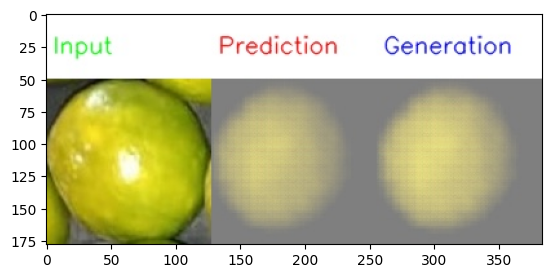

In [20]:
read_image= cv2.imread(filename_list[read_index])
img=read_image[:,:,::-1]
plt.imshow(img)

In [34]:
read_index=4

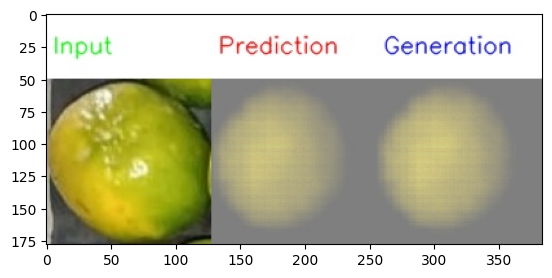

In [35]:
read_image= cv2.imread(filename_list[read_index])
img=read_image[:,:,::-1]
plt.imshow(img)

In [40]:
read_index= 5

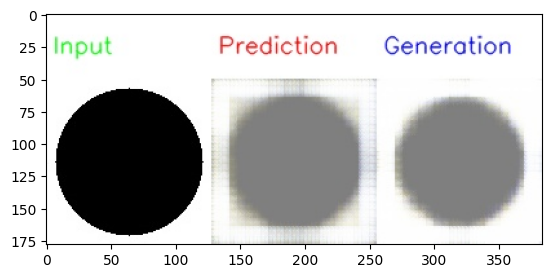

In [41]:
read_image= cv2.imread(filename_list[read_index])
img=read_image[:,:,::-1]
plt.imshow(img)